Querying some models can be very expensive, taking up to a couple of hours for one input. Hence, algorithms like MCMC that require numerous samples become impractical. However, by using an emulator, i.e. an approximation to the model, we can make a tradeoff between accuracy and speed. This notebooks shows how Emulator based on Gaussian Processes in pints can be used to model the log_likelihood of a Logistic Model.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import emupints 
import emupints.utils as emutils
import emupints.plot as emuplt

import copy

%matplotlib inline

# Creating the model 

First we need to create an instance of a problem(model), this is a common pattern in pints

In [2]:
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Create bounds for our parameters
boundaries = pints.Boundaries([0.01, 400], [0.02, 600])


# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

In [3]:
# Create a uniform prior over parameters
log_prior = pints.UniformLogPrior(
    boundaries
)

## Generating training data

To create an emulator we need to provide it with data to train on.

In [4]:
input_parameters = log_prior.sample(400)
input_parameters[:5]

array([[1.54465838e-02, 4.37453551e+02],
       [1.99292081e-02, 4.34437592e+02],
       [1.56922256e-02, 5.53292201e+02],
       [1.28184788e-02, 4.62450359e+02],
       [1.96869859e-02, 4.37457365e+02]])

In [5]:
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

array([-12941.82875119, -28806.02443699, -13965.73644811, -22376.10892456,
       -26947.00456498])

## Create and train a GP emulator

Emulator is initialized by providing the instance of likelihood PDF being emulated, input array of shape $N \times n\_parameters$ and a target array of shape $N \times 1$. 
When using Gaussian Processes we standardize inputs and outputs, this helps GP to get a better fit as it assumes that the mean of the GP is 0, so it helps if the input data meets this criteria. Standardizing inputs is also usefull, as it helps to select initial parameters for the covariance function.
<br>
<br>
Similarly to skleark, emupints emulators follow initialize-fit-predict pattern, but instead of emulators having .predict method they are callable

In [6]:
emu = emupints.GPEmulator(log_likelihood, 
                          input_parameters, 
                          likelihoods,
                          normalize_input = True)
emu.set_parameters(kernel = GPy.kern.Linear(emu.n_parameters()))
emu.fit(normalizer = True)
emu.summary()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0008   5.415549e+02   3.594806e+01 
    00s13  0014   5.401944e+02   3.835834e-01 
    00s18  0018   5.401852e+02   6.797325e-08 
Runtime:     00s18
Optimization status: Converged

Summary
Kernel:
   linear.    |                value  |  constraints  |  priors
  variances  |  0.07157574629029588  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  default

Name : GP regression
Objective : 540.1852039003393
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  linear.variances         |  0.07157574629029588  |      +ve      |        
  Gaussian_noise.variance  |   0.8567218677254672  |      +ve      |        


Now we can query prediction from the emulator just like we can from any log-pdf. Since the output of a GP is a normal distribution, we just automatically sample from it. To get the mean and variance at a particular point you can use emu.predict function

In [7]:
emu([0.015, 500])

array([[-28611.51369519]])

## Surface plots

To visuallize the performance of our emulator it's usefull to look at the surface plots <br>

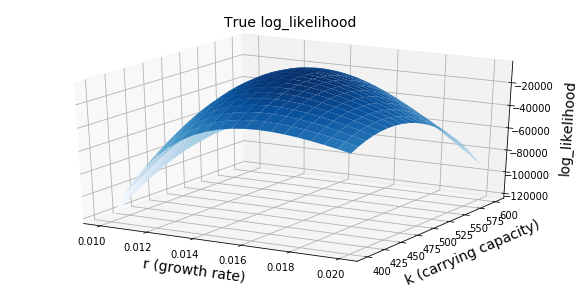

In [8]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = emutils.generate_grid(boundaries.lower(), 
                                                  boundaries.upper(), 
                                                  test_splits)

model_prediction = emutils.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
emuplt.surface(r_grid, k_grid, model_prediction, title = "True log_likelihood",
                     x_label = "r (growth rate)",
                     y_label = "k (carrying capacity)")

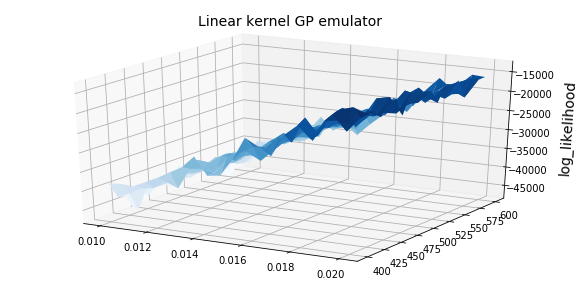

In [9]:
emu_prediction = emutils.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = emuplt.surface(r_grid, 
                    k_grid, 
                    emu_prediction, 
                    title = "Linear kernel GP emulator")

Plotting the difference between the surfaces can show where models differ the most

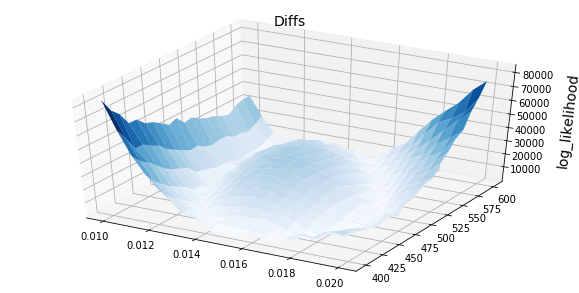

In [10]:
diffs = np.abs(model_prediction - emu_prediction)

plt.figure(figsize = (10, 5))
ax = emuplt.surface(r_grid, 
                    k_grid, 
                    diffs, 
                    title = "Diffs", 
                    angle = (40, 300))

## Comparison of different kernels

Now we try a number of different kernels to find out which ones work the best for Logistic ODE. Note, an important feature of kernels is that they can be added and multiplied together to produce new kernels. <br>
We use log_marginal_likelihood to as a objective functino for GP's performance

In [11]:
input_dim = 2
kernels_and_names = [
    (GPy.kern.White(input_dim), "White"),
    (GPy.kern.Linear(input_dim), "Linear"),
    (GPy.kern.Matern52(input_dim), "Matern52"),
    (GPy.kern.RBF(input_dim), "RBF"),
    (GPy.kern.MLP(input_dim), "MLP"),
    (GPy.kern.RatQuad(input_dim), "RatQuad"),
    # combinations
    (GPy.kern.Linear(input_dim) * GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim), "Linear * Linear + White"),
    (GPy.kern.RBF(input_dim) * GPy.kern.RBF(input_dim), "RBF * RBF"),
    (GPy.kern.Matern52(input_dim, variance = 1.) + GPy.kern.RBF(input_dim, variance = 1.), "Matern52 + RBF"),
    (GPy.kern.RBF(input_dim) + GPy.kern.RBF(input_dim, lengthscale = 0.01) * GPy.kern.RBF(input_dim), 
     "RBF + RBF[variance=0.01]*RBF"),
]

# differents optimizers:
# SCG
# possible optimizers: ‘scg’, ‘lbfgs’, ‘tnc’.
# 'scg' and 'tnc' require the data to be normalized
#  can put the max on the number of iterations using max_iter = 100
# 'lbfgs' seems to be the default and performs well for MLP and RatQuad
optimizer = 'lbfgs'
emu.set_parameters(optimizer=optimizer)

 /Users/maksympetyak/Prog/emupints/emupints/_gp_emulator.py:59: UserWarning:Non-negative log_likelihood predicted.Indicative of high uncertainty in predictions.
 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.


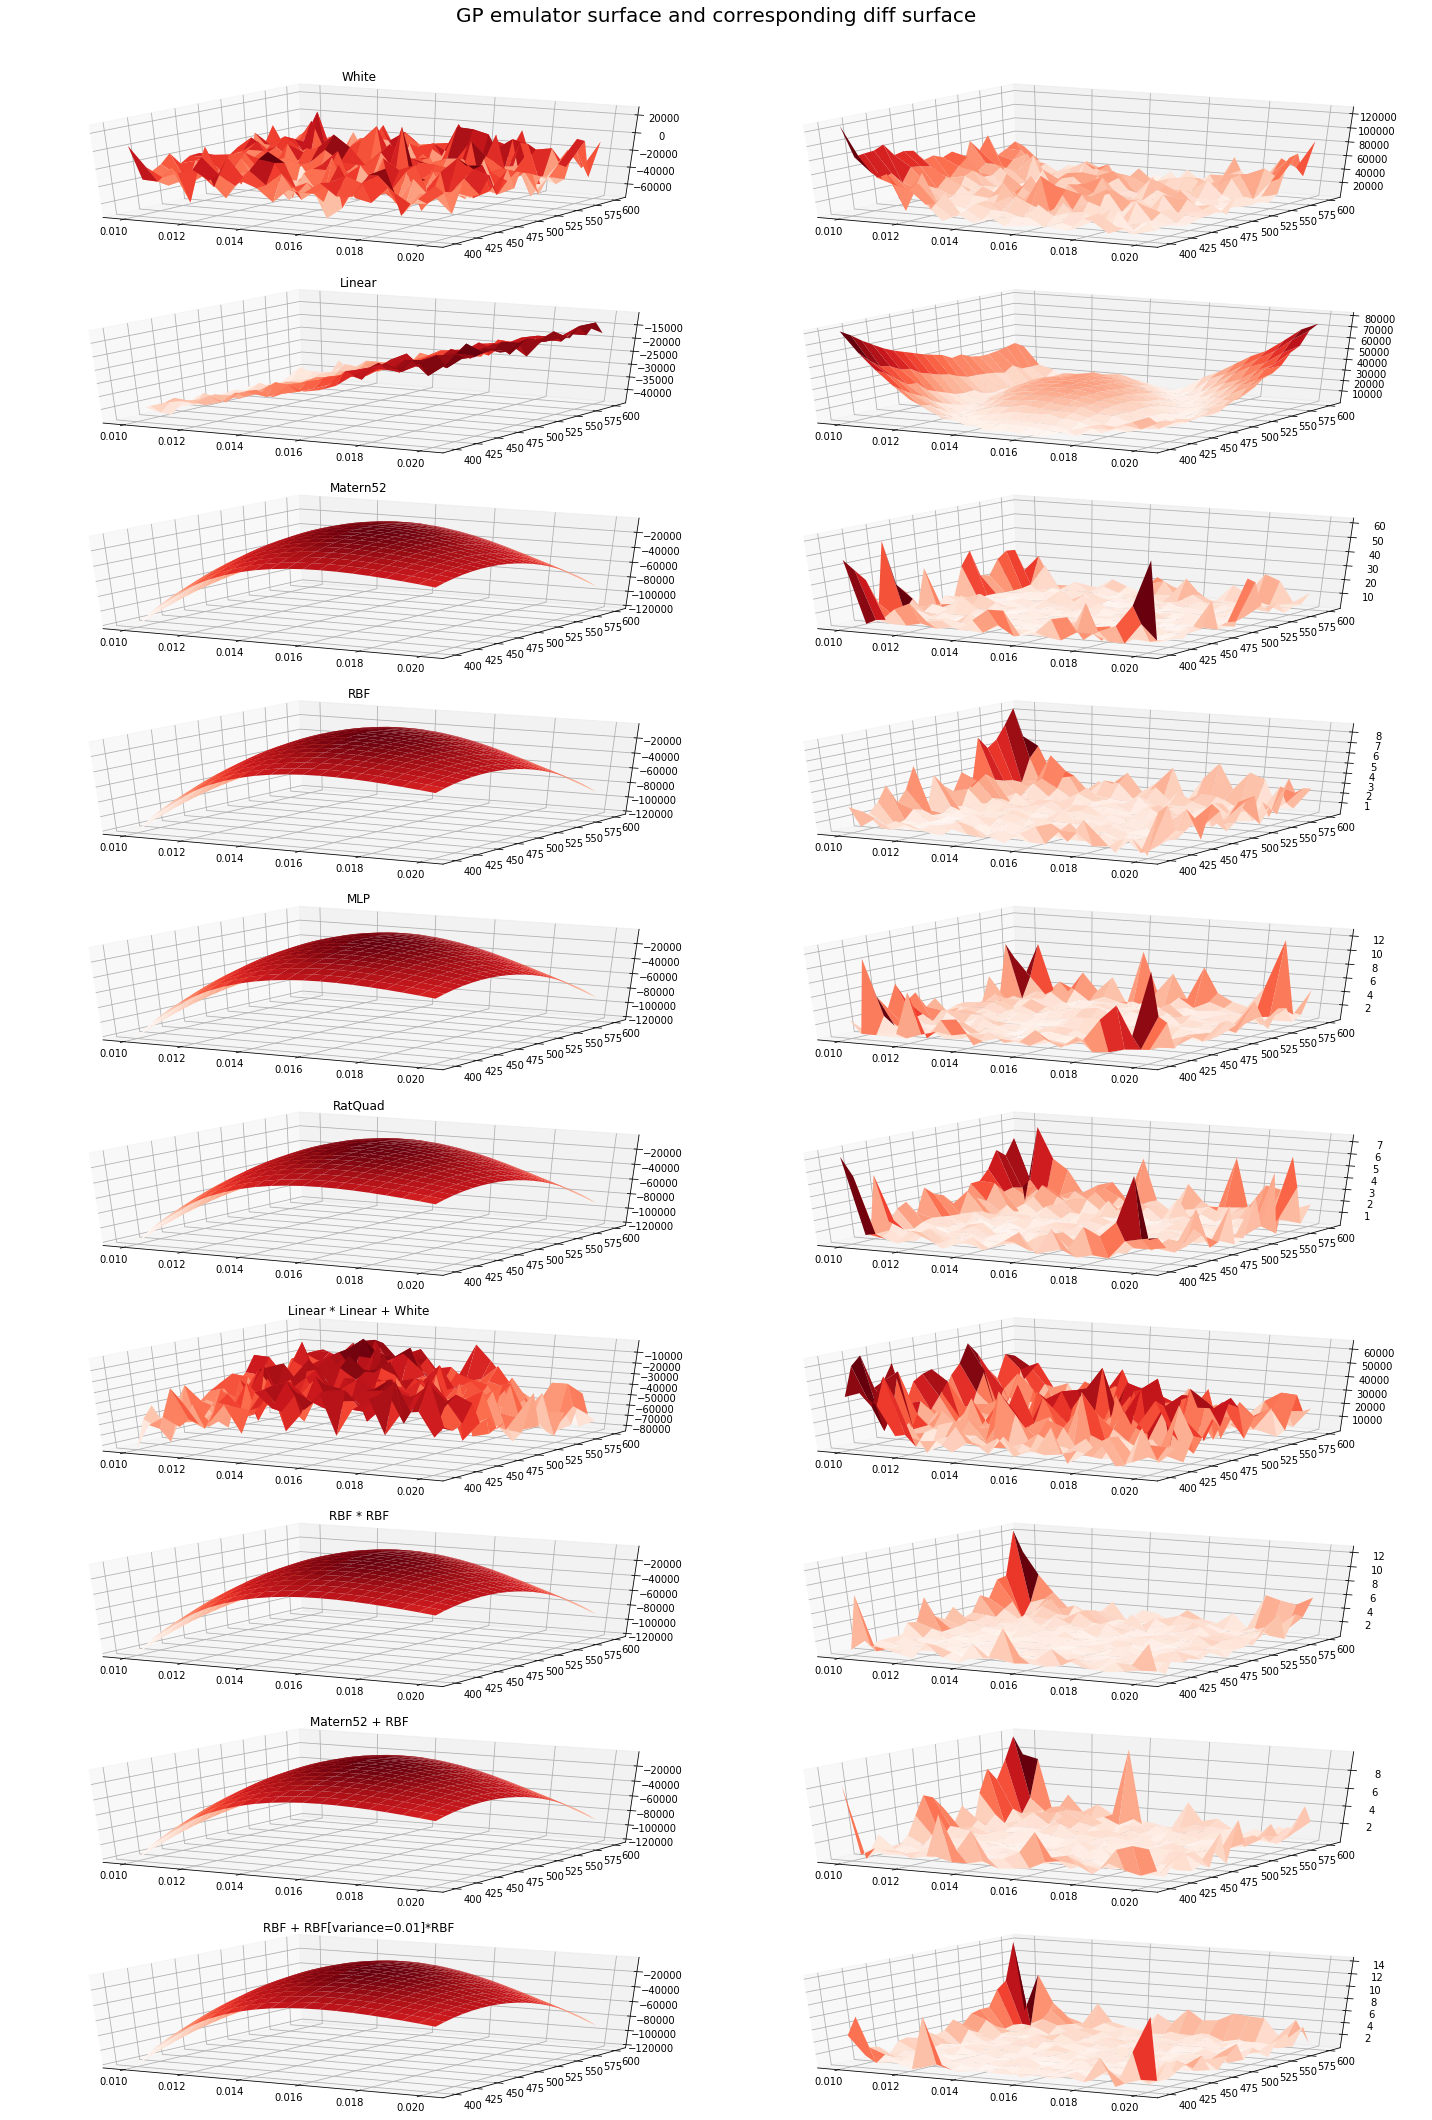

In [12]:
l = len(kernels_and_names)

marginal_log_likelihoods = []

fig = plt.figure(figsize = (20, 30))


for row in range(l):

    kernel, name = kernels_and_names[row]
    
    
    emu.set_parameters(kernel = kernel)
    emu.fit(messages = False, normalizer = True) # change of parameters requires the model to be refitted
    emu_prediction = emutils.predict_grid(emu, test_data)
    diffs = np.abs(model_prediction - emu_prediction)
    
    # store errors
    marginal_log_likelihoods.append(emu.get_log_marginal_likelihood())
    
    # plot surface of GP
    gp = emu.get_gp()
    ax1 = fig.add_subplot(l, 2, 2*row + 1, projection = '3d')
    #ax1.set_zlim(-800000, 0)
    ax1.set_title(name)
    ax1.plot_surface(r_grid, k_grid, emu_prediction, cmap = "Reds")
    
    # plot diffs surface
    ax2 = fig.add_subplot(l, 2, 2*row + 2, projection = '3d')
    #ax2.set_zlim(0, 700000)
    ax2.plot_surface(r_grid, k_grid, diffs, cmap = "Reds")

fig.suptitle("GP emulator surface and corresponding diff surface", 
             fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show(fig)

Most non-trivial kernels perform pretty well, although all of them find it hard to capture the peak when r is close to zero

In [13]:
marginal_log_likelihoods

[-567.575413281869,
 -540.1852039003393,
 2411.6832490764755,
 2961.1607610897613,
 2908.730216345344,
 2979.4953034704267,
 -490.4426834856319,
 2961.172699650215,
 2961.154158236973,
 2961.1552625225145]

In [14]:
optimal_kern = kernels_and_names[np.argmax(marginal_log_likelihoods)][0]
optimal_kern

RatQuad.,value,constraints,priors
variance,89757.39319263189,+ve,
lengthscale,7.3853553358225845,+ve,
power,0.30704353551312313,+ve,


In [15]:
emu.set_parameters(kernel = optimal_kern)
emu.fit(normalizer = True, messages = False)
emu.summary()

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Summary
Kernel:
   RatQuad.     |                value  |  constraints  |  priors
  variance     |    89757.39320652539  |      +ve      |        
  lengthscale  |    7.384583209398788  |      +ve      |        
  power        |  0.31589663996038725  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  lbfgs

Name : GP regression
Objective : -2979.2036212195403
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  RatQuad.variance         |      89757.39320652539  |      +ve      |        
  RatQuad.lengthscale      |      7.384583209398788  |      +ve      |        
  RatQuad.power            |    0.31589663996038725  |      +ve      |        
  Gaussian_noise.variance  |  9.455956118927911e-12  |      +ve      |        


## Plotting GP

In addition to functions provided by emuplt, it's possible to retrieve the GPy emulator and use GPy's functions for visualization. 

In [16]:
gp = emu.get_gp()

 /anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


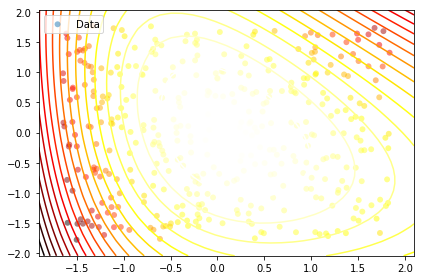

In [17]:
fig = gp.plot()
fig

# Slicing

GP's allow to gauge the measure of uncertainty in prediction by looking at variance for different inputs. 
Here we take a linear kernel, as it was a bad fit, and see how uncertainty changes depending on value of second parameter. Linear kernel is quite close to the model (low uncertainty) near the true value for second parameter (500).

In [18]:
slice_emu = emupints.GPEmulator(log_likelihood, 
                                input_parameters, 
                                likelihoods,
                                normalize_input = True)
slice_emu.set_parameters(kernel = GPy.kern.Linear(input_dim))
slice_emu.fit(messages = False, normalizer = True)

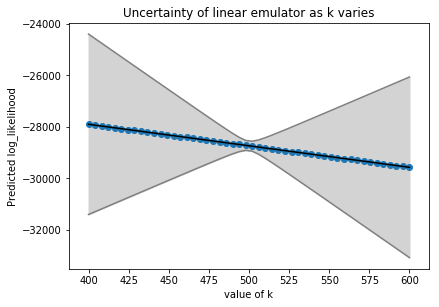

In [19]:
test_k_range = np.linspace(400, 600, 50)
r_slice_val = 0.015
r_arr = np.zeros(len(test_k_range)) + r_slice_val
slice_data = np.dstack((r_arr, test_k_range)).squeeze()
slice_data

#prediction returns mean and variance
mean, var = slice_emu.predict(slice_data)
# convert to 1D
mean, var = mean.flatten(), var.flatten()

#for 95% confidence add/subtract 2 std
conf = 2 * np.sqrt(var)


fig, ax = emuplt.confidence_interval(test_k_range, mean, conf)
plt.title("Uncertainty of linear emulator as k varies")
plt.ylabel("Predicted log_likelihood")
plt.xlabel("value of k")
plt.show(fig)

## Using the emulator

In [20]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(emu, log_prior)

We use the resulting posterior as we normally would in pints

In [21]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]
xs

[array([1.35e-02, 4.50e+02]),
 array([1.575e-02, 5.250e+02]),
 array([1.725e-02, 5.750e+02])]

In [22]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0.25      0         0          0:00.0
20    63     0.143     0         0.0952     0:00.0
40    123    0.0732    0.0244    0.0488     0:00.0
60    183    0.0492    0.0164    0.0328     0:00.1
80    243    0.0494    0.0123    0.0247     0:00.1
100   303    0.0396    0.0099    0.0198     0:00.1
120   363    0.0496    0.0165    0.0165     0:00.1
140   423    0.0496    0.0142    0.0142     0:00.1
160   483    0.0435    0.0124    0.0124     0:00.2
180   543    0.0387    0.011     0.011      0:00.2
200   603    0.0348    0.00995   0.00995    0:00.2
220   663    0.0543    0.0271    0.0136     0:00.2
240   723    0.0788    0.0415    0.029      0:00.3
260   783    0.123     0.069     0.0613     0:00.3
28

3200  9603   0.305     0.307     0.326      0:06.8
3220  9663   0.305     0.306     0.327      0:06.8
3240  9723   0.305     0.306     0.326751   0:06.9
3260  9783   0.305     0.307     0.327      0:06.9
3280  9843   0.304     0.307     0.326      0:07.0
3300  9903   0.305     0.307     0.326      0:07.0
3320  9963   0.305     0.306     0.326      0:07.1
3340  10023  0.306     0.305     0.326      0:07.1
3360  10083  0.306     0.304     0.325      0:07.1
3380  10143  0.307     0.303     0.326      0:07.2
3400  10203  0.306     0.302264  0.325      0:07.2
3420  10263  0.306     0.303     0.324      0:07.3
3440  10323  0.306     0.304     0.324      0:07.3
3460  10383  0.306     0.303     0.324      0:07.4
3480  10443  0.305372  0.304     0.323      0:07.4
3500  10503  0.305     0.304     0.322      0:07.4
3520  10563  0.305311  0.303     0.321      0:07.5
3540  10623  0.305     0.302     0.321      0:07.5
3560  10683  0.305     0.302     0.321      0:07.6
3580  10743  0.306     0.303   

6420  19263  0.3       0.299     0.308      0:13.8
6440  19323  0.3       0.298     0.308      0:13.9
6460  19383  0.299644  0.299     0.307      0:13.9
6480  19443  0.3       0.299     0.308      0:14.0
6500  19503  0.3       0.299     0.308      0:14.0
6520  19563  0.3       0.299     0.308      0:14.1
6540  19623  0.3       0.299     0.307      0:14.1
6560  19683  0.3       0.299     0.307      0:14.1
6580  19743  0.3       0.299     0.307      0:14.2
6600  19803  0.300106  0.3       0.307      0:14.2
6620  19863  0.301     0.299     0.307      0:14.3
6640  19923  0.301     0.3       0.307      0:14.3
6660  19983  0.302     0.3       0.307011   0:14.4
6680  20043  0.302     0.3       0.307      0:14.4
6700  20103  0.301     0.3       0.307      0:14.5
6720  20163  0.301     0.3       0.307      0:14.5
6740  20223  0.301439  0.3       0.307      0:14.5
6760  20283  0.302     0.3       0.307      0:14.6
6780  20343  0.302     0.3       0.308      0:14.6
6800  20403  0.302     0.30025 

9720  29163  0.301     0.3       0.307      0:21.2
9740  29223  0.301     0.3       0.307      0:21.2
9760  29283  0.301     0.3       0.307      0:21.2
9780  29343  0.301094  0.3       0.307      0:21.3
9800  29403  0.301     0.3       0.307      0:21.3
9820  29463  0.301     0.3       0.307      0:21.4
9840  29523  0.3       0.3       0.308      0:21.4
9860  29583  0.3       0.299     0.308      0:21.5
9880  29643  0.3       0.299     0.308      0:21.5
9900  29703  0.3       0.299     0.308      0:21.5
9920  29763  0.3       0.3       0.307      0:21.6
9940  29823  0.3       0.3       0.307      0:21.6
9960  29883  0.301     0.299     0.307      0:21.7
9980  29943  0.301     0.299     0.308      0:21.7
10000 30000  0.3012    0.2988    0.3076     0:21.7
Halting: Maximum number of iterations (10000) reached.


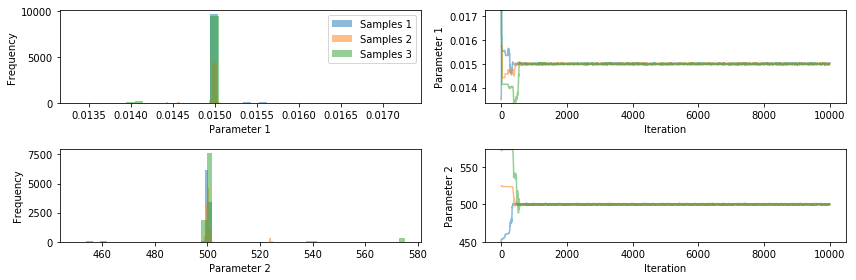

In [23]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Compare this with the parameter estimation for the original likelihood

In [24]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [25]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.0476    0         0.0952     0:00.0
40    123    0.0244    0         0.0732     0:00.0
60    183    0.0164    0.0164    0.0492     0:00.0
80    243    0.0123    0.0123    0.0617     0:00.0
100   303    0.0297    0.0099    0.0594     0:00.1
120   363    0.0248    0.00826   0.0579     0:00.1
140   423    0.0213    0.0142    0.0567     0:00.1
160   483    0.0186    0.0124    0.0559     0:00.1
180   543    0.0221    0.011     0.0497     0:00.1
200   603    0.0249    0.00995   0.0448     0:00.1
220   663    0.0362    0.00905   0.0452     0:00.1
240   723    0.0747    0.0498    0.0539     0:00.1
260   783    0.0805    0.0843    0.0766     0:00.1
28

3260  9783   0.309     0.315854  0.317      0:02.1
3280  9843   0.309     0.314843  0.317      0:02.1
3300  9903   0.308     0.315     0.318      0:02.2
3320  9963   0.308     0.316     0.319      0:02.2
3340  10023  0.308     0.317     0.318      0:02.2
3360  10083  0.307     0.31687   0.318      0:02.2
3380  10143  0.307     0.316     0.317066   0:02.2
3400  10203  0.307     0.316     0.318      0:02.2
3420  10263  0.307     0.316     0.317      0:02.2
3440  10323  0.307     0.316     0.317      0:02.2
3460  10383  0.307     0.316     0.317      0:02.3
3480  10443  0.308     0.315     0.317      0:02.3
3500  10503  0.309     0.315     0.316      0:02.3
3520  10563  0.309     0.316     0.316      0:02.3
3540  10623  0.31      0.315     0.315      0:02.3
3560  10683  0.31      0.31508   0.316      0:02.3
3580  10743  0.309     0.315     0.315      0:02.3
3600  10803  0.31      0.314     0.316      0:02.4
3620  10863  0.31      0.314     0.317      0:02.4
3640  10923  0.309805  0.314   

6660  19983  0.306     0.307     0.311      0:04.4
6680  20043  0.305     0.307     0.31163    0:04.5
6700  20103  0.305626  0.307     0.312      0:04.5
6720  20163  0.306     0.307     0.311      0:04.5
6740  20223  0.306186  0.306     0.311      0:04.5
6760  20283  0.306     0.306     0.310457   0:04.5
6780  20343  0.307     0.306297  0.31       0:04.5
6800  20403  0.307     0.306     0.31       0:04.6
6820  20463  0.307     0.306     0.31       0:04.6
6840  20523  0.307     0.305     0.31       0:04.6
6860  20583  0.307     0.305     0.31       0:04.6
6880  20643  0.306     0.305     0.309984   0:04.6
6900  20703  0.306     0.305     0.31       0:04.6
6920  20763  0.307     0.305     0.309      0:04.7
6940  20823  0.307     0.304     0.31       0:04.7
6960  20883  0.306     0.304     0.309      0:04.7
6980  20943  0.306     0.304     0.31       0:04.7
7000  21003  0.307     0.304     0.31       0:04.7
7020  21063  0.307     0.304     0.31       0:04.7
7040  21123  0.307     0.304   

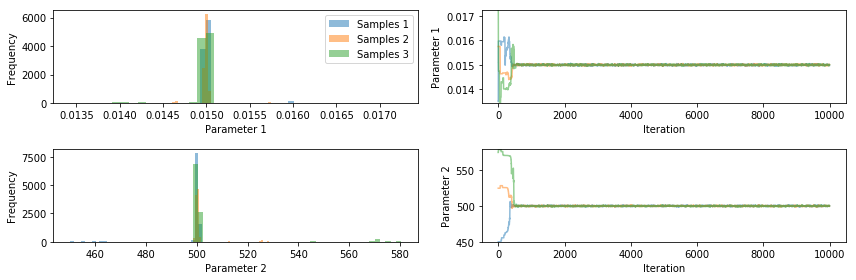

In [26]:
pints.plot.trace(chains)
plt.show()

Plotting likelihood differences along one chain

In [27]:
chain = chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()

diffs = np.abs(model_prediction - emu_prediction)

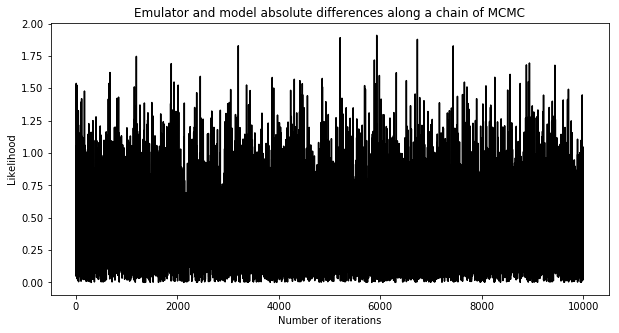

In [28]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

This shows us that a emulator is a good fit, as during the execution of MCMC emulator is likely to return values that are close (+/- 4) to the real values

Let's now see the progression of one of the chains

In [29]:
r_vals = chain[:, 0]
k_vals = chain[:, 1]
print(r_vals.shape, k_vals.shape)

(10000,) (10000,)


In [30]:
test_split = 50
r_min, r_max = r_vals.min(), r_vals.max()
k_min, k_max = k_vals.min(), k_vals.max()
r_grid, k_grid, test_data = emutils.generate_grid([r_min, k_min], [r_max, k_max], test_splits)

In [31]:
model_prediction = emutils.predict_grid(log_likelihood, test_data)
emu_prediction = emutils.predict_grid(emu, test_data)
diffs = model_prediction - emu_prediction

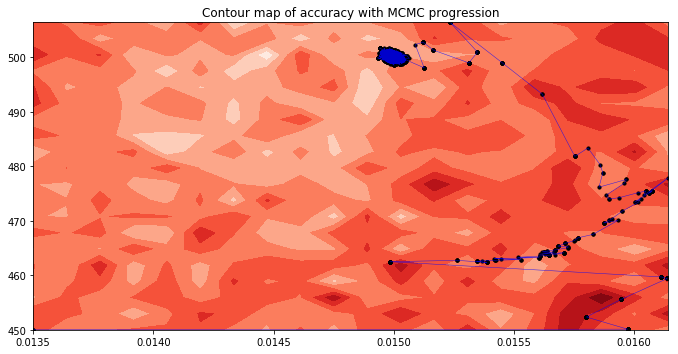

In [32]:
fig, ax = emuplt.contour(r_grid, k_grid, diffs, cmap = "Reds", fill = True)
fig.set_size_inches((10, 5))
ax.plot(r_vals, k_vals, color = 'blue', alpha = 0.8, linewidth = 0.5)
ax.scatter(r_vals, k_vals, color = 'black', s = 10)

ax.set_title("Contour map of accuracy with MCMC progression")
# scatter plot causes some points to leave the axis so we need to manually specify bounds
ax.set_xlim(r_grid.min(), r_grid.max())
ax.set_ylim(k_grid.min(), k_grid.max())
plt.show()

It's clear that MCMC climbs quite quickly to the values near the true parameter values [.015, 500], and most of the points after initial 100 are concentrated there. Hence, when training the model it's better to include training data that has high likelihood, as it's very likely that the emulator will be approaching that area. (Active sampling) <br>
Alternatively, makes sure that the bounds for each parameter are small, as otherwise GP will have a hard time correctly estimating the required small region.